## First Level Analysis

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
from nipype.interfaces import spm
from nipype.interfaces import fsl
from nipype.interfaces import matlab as mlab

In [2]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath('./Documents/MATLAB/spm12/'), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [3]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath('./Documents/MATLAB/spm12/'))

In [4]:
spm.SPMCommand().version

stty: 'standard input': Inappropriate ioctl for device


In [5]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [6]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [7]:
data_dir = os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json')

In [7]:
experiment_dir = os.path.join(base_dir, 'output')
output_dir = 'block_preproc'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01']

# TR of functional images
with open(os.path.join(base_dir, 'MoAEpilot/task-auditory_bold.json'), 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing width used during preprocessing
fwhm = [6]

In [8]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
level1design = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1,
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=8,
                                 microtime_resolution=16,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=False, 
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [9]:
# Condition names
condition_names = ['listening']
#onsets = [6,18, 30, 42, 54, 66, 78]
# Contrasts
#onsets = ['listening',      'T', condition_names, [6, 18, 30, 42, 54, 66, 78]
cont01 = ['listening > rest','T', condition_names, [1, 0]]

contrast_list = [cont01]

In [30]:
!cat ./spmbasics/data/MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv

onset	duration	trial_type
42	42	listening
126	42	listening
210	42	listening
294	42	listening
378	42	listening
462	42	listening
546	42	listening


In [11]:
import pandas as pd
trialinfo = pd.read_table(os.path.join(base_dir, 'MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv'))
trialinfo

,onset,duration,trial_type
0,42,42,listening
1,126,42,listening
2,210,42,listening
3,294,42,listening
4,378,42,listening
5,462,42,listening
6,546,42,listening


In [12]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

('listening',    onset  duration trial_type
0     42        42  listening
1    126        42  listening
2    210        42  listening
3    294        42  listening
4    378        42  listening
5    462        42  listening
6    546        42  listening)



In [10]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table(os.path.join(base_dir, 'MoAEpilot/sub-01/func/sub-01_task-auditory_events.tsv'))
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          tmod=None,
                          pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [11]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': os.path.join(output_dir, 'sub-{subject_id}', 'task-{task_id}',
                         'sub-{subject_id}_task-{task_id}_bold.nii'),
             'mc_param': os.path.join(output_dir, 'sub-{subject_id}', 'task-{task_id}',
                             'sub-{subject_id}_task-{task_id}_bold.par'),
             'outliers': os.path.join(output_dir, 'sub-{subject_id}', 'task-{task_id}', 
                             'art.sub-{subject_id}_task-{task_id}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'auditory'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [12]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = os.path.join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

240515-14:29:54,156 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/l1analysis/colored_l1analysis.png (graph2use=colored, simple_form=True).


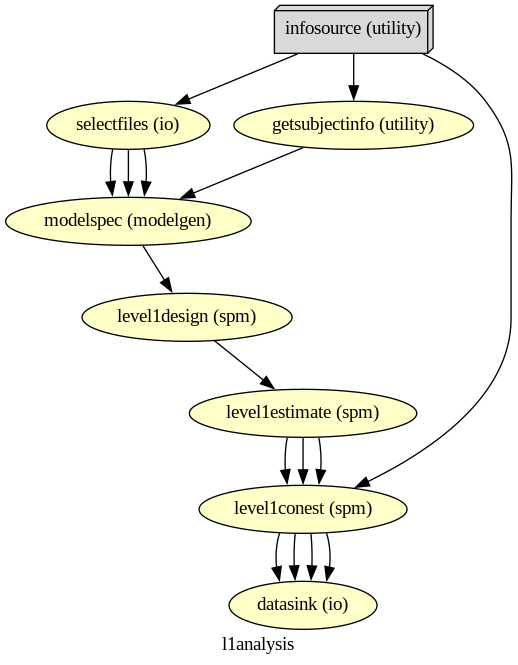

In [13]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', dotfilename='colored_l1analysis.dot', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(l1analysis.base_dir, 'l1analysis', 'colored_l1analysis.png'))

In [14]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

240515-14:29:58,578 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
240515-14:29:58,587 nipype.workflow INFO:
	 Running in parallel.
240515-14:29:58,588 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240515-14:29:58,654 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/l1analysis/_subject_id_01/selectfiles".
240515-14:29:58,655 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/home/matay/spmbasics/data/output/workingdir/l1analysis/_subject_id_01/getsubjectinfo".
240515-14:29:58,659 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240515-14:29:58,659 nipype.workflow INFO:
	 [Node] Executing "getsubjectinfo" <nipype.interfaces.utility.wrappers.Function>
240515-14:29:58,662 nipype.workflow INFO:
	 [Node] Finished "getsubjectinfo",

RuntimeError: 2 raised. Re-raising first.

In [8]:
grabber =  Node(DataGrabber(infields=['subject_id'],
                      outfields=['anat', 'func']),
          name='datagrabber')

grabber.inputs.base_directory = os.path.join(base_dir, 'MoAEpilot_raw/')

grabber.inputs.template = '*'
grabber.inputs.sort_filelist = True

# specify the template
grabber.inputs.template_args = {'anat': [['subject_id']],
                           'func': [['subject_id', 'task_name']]}
grabber.inputs.field_template = {'anat': 'sub-%02d/anat/*_T1w.nii',
                            'func': 'sub-%02d/func/*_task-%s_bold.nii'}

grabber.inputs.subject_id = 1
grabber.inputs.task_name = "auditory"

In [9]:
realigner = Node(interface=spm.Realign(), name='realign')
# realigner.inputs.in_files = func_file
realigner.inputs.register_to_mean = True
realigner.inputs.fwhm = 5
realigner.inputs.interp = 2
realigner.inputs.quality = 0.9
realigner.inputs.separation = 4
realigner.inputs.wrap = [0, 0, 0]
realigner.inputs.write_which = [2, 1]
realigner.inputs.write_interp = 4 
realigner.inputs.write_wrap = [0, 0, 0]
realigner.inputs.jobtype = 'estwrite'
realigner.inputs.out_prefix = 'r'

In [10]:
slicetiming = Node(interface=spm.SliceTiming(), name = 'slicetiming')
# st.inputs.in_files = anat_file
slicetiming.inputs.num_slices = 64
slicetiming.inputs.time_repetition = 7.
slicetiming.inputs.time_acquisition = 6.8906
slicetiming.inputs.slice_order = list(range(64,0,-1))
slicetiming.inputs.ref_slice = 32
slicetiming.inputs.out_prefix = 'a'

In [11]:
coregister = Node(spm.Coregister(), name="coregister")
coregister.inputs.jobtype = 'estimate'
coregister.inputs.cost_function = 'nmi'
coregister.inputs.fwhm = [7.0, 7.0]
coregister.inputs.separation = [4.0, 2.0]
coregister.inputs.tolerance = [0.02, 0.02, 0.02, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001]
#coregister.inputs.target = './data/preproc/realign/meansub-01_task-auditory_bold.nii'
#coregister.inputs.source = './data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
# coregister.inputs.apply_to_files = './data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'

In [12]:
tpm_path = os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/tpm/', 'TPM.nii'))

In [13]:
segment =  Node(spm.NewSegment(), name="newsegment")
# seg.inputs.channel_files = '/data/preproc/coregister/sub-01_T1w.nii'
#seg.inputs.channel_files = '/data/MoAEpilot_raw/sub-01/anat/sub-01_T1w.nii'
segment.inputs.affine_regularization = 'mni'
segment.inputs.channel_info = (0.001, 60, (False, True)) #save bias corrected map
tissue1 = ((tpm_path, 1), 1, (True, False), (False, False))
tissue2 = ((tpm_path, 2), 1, (True, False), (False, False))
tissue3 = ((tpm_path, 3), 2, (True, False), (False, False))
tissue4 = ((tpm_path, 4), 3, (True, False), (False, False))
tissue5 = ((tpm_path, 5), 4, (True, False), (False, False))
tissue6 = ((tpm_path, 6), 2, (False, False), (False, False))
segment.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
segment.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
segment.inputs.sampling_distance = 3
segment.inputs.write_deformation_fields = [False, True] 

stty: 'standard input': Inappropriate ioctl for device


In [14]:
normalize = Node(spm.Normalize12(), name="normalize") #old normalize now
#normalize.inputs.deformation_file = '/data/preproc/segment/y_sub-01_T1w.nii'
#normalize.inputs.apply_to_files = '/data/preproc/slicetiming/arsub-01_task-auditory_bold.nii'
normalize.inputs.jobtype = 'write'
normalize.inputs.write_bounding_box =  [[-78, -112, -70], [78, 76, 85]]
normalize.inputs.write_voxel_sizes = [3, 3, 3]
normalize.inputs.write_interp = 4
normalize.inputs.out_prefix = 'w'

In [15]:
smooth = Node(spm.Smooth(), name="smooth")
# smooth.inputs.in_files = '/data/preproc/normalize/warsub-01_task-auditory_bold.nii'
smooth.inputs.fwhm = [6, 6, 6]
smooth.inputs.data_type = 0
smooth.inputs.implicit_masking = False
smooth.inputs.out_prefix = 's'

In [16]:
sink = Node(interface=DataSink(),
                   name='sink')
sink.inputs.base_directory = os.path.join(base_dir, 'output')
#sink.inputs.regexp_substitutions = [('_\w+\d+', '.')]

In [17]:
preproc.connect([(grabber, realigner, [('func', 'in_files')]),
                 (realigner, slicetiming, [('realigned_files', 'in_files')]),
                 (realigner, coregister, [('mean_image', 'target')]),
                 (grabber, coregister, [('anat', 'source')]), 
                (coregister, segment, [('coregistered_source', 'channel_files')]),
                (segment, normalize, [('forward_deformation_field', 'deformation_file')]),
                (slicetiming, normalize, [('timecorrected_files', 'apply_to_files')]),
                 (normalize, smooth, [('normalized_files', 'in_files')]),
])

240502-18:06:03,463 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/block_preproc0/graph.png (graph2use=colored, simple_form=True).


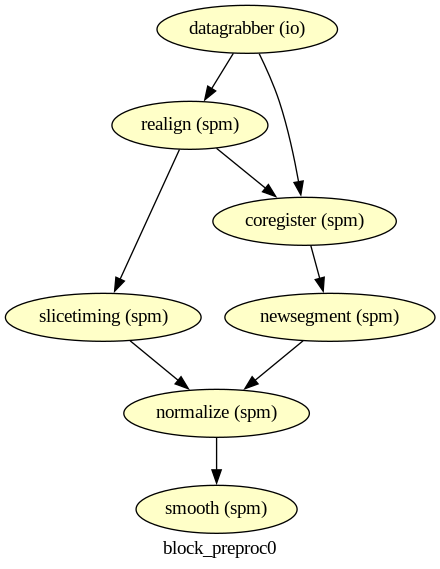

In [20]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='./spmbasics/data/output/block_preproc0/graph.png', width=750)

In [18]:
preproc.write_graph(graph2use='flat', format='png', simple_form=True)

240502-18:14:31,602 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/block_preproc1/graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/block_preproc1/graph.png'

In [19]:
preproc.run()

240502-18:14:35,545 nipype.workflow INFO:
	 Workflow block_preproc1 settings: ['check', 'execution', 'logging', 'monitoring']
240502-18:14:35,549 nipype.workflow INFO:
	 Running serially.
240502-18:14:35,550 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.datagrabber" in "/home/matay/spmbasics/data/output/block_preproc1/datagrabber".
240502-18:14:35,552 nipype.workflow INFO:
	 [Node] Executing "datagrabber" <nipype.interfaces.io.DataGrabber>
240502-18:14:35,554 nipype.workflow INFO:
	 [Node] Finished "datagrabber", elapsed time 0.000876s.
240502-18:14:35,557 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.realign" in "/home/matay/spmbasics/data/output/block_preproc1/realign".
240502-18:14:35,580 nipype.workflow INFO:
	 [Node] Executing "realign" <nipype.interfaces.spm.preprocess.Realign>


stty: 'standard input': Inappropriate ioctl for device


240502-18:15:06,217 nipype.workflow INFO:
	 [Node] Finished "realign", elapsed time 23.348648s.
240502-18:15:06,222 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.slicetiming" in "/home/matay/spmbasics/data/output/block_preproc1/slicetiming".
240502-18:15:06,225 nipype.workflow INFO:
	 [Node] Executing "slicetiming" <nipype.interfaces.spm.preprocess.SliceTiming>


stty: 'standard input': Inappropriate ioctl for device


240502-18:15:19,712 nipype.workflow INFO:
	 [Node] Finished "slicetiming", elapsed time 13.48703s.
240502-18:15:19,716 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.coregister" in "/home/matay/spmbasics/data/output/block_preproc1/coregister".
240502-18:15:19,722 nipype.workflow INFO:
	 [Node] Executing "coregister" <nipype.interfaces.spm.preprocess.Coregister>


stty: 'standard input': Inappropriate ioctl for device


240502-18:15:32,454 nipype.workflow INFO:
	 [Node] Finished "coregister", elapsed time 12.731121s.
240502-18:15:32,456 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.newsegment" in "/home/matay/spmbasics/data/output/block_preproc1/newsegment".
240502-18:15:32,459 nipype.workflow INFO:
	 [Node] Executing "newsegment" <nipype.interfaces.spm.preprocess.NewSegment>


stty: 'standard input': Inappropriate ioctl for device


240502-18:16:23,5 nipype.workflow INFO:
	 [Node] Finished "newsegment", elapsed time 50.545137s.
240502-18:16:23,11 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.normalize" in "/home/matay/spmbasics/data/output/block_preproc1/normalize".
240502-18:16:23,30 nipype.workflow INFO:
	 [Node] Executing "normalize" <nipype.interfaces.spm.preprocess.Normalize12>


stty: 'standard input': Inappropriate ioctl for device


240502-18:16:38,600 nipype.workflow INFO:
	 [Node] Finished "normalize", elapsed time 15.568788s.
240502-18:16:38,609 nipype.workflow INFO:
	 [Node] Setting-up "block_preproc1.smooth" in "/home/matay/spmbasics/data/output/block_preproc1/smooth".
240502-18:16:38,611 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.spm.preprocess.Smooth>


stty: 'standard input': Inappropriate ioctl for device


240502-18:16:50,11 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 11.398597s.


stty: 'standard input': Inappropriate ioctl for device


### first level analysis